# 2.Amazon_SageMaker_RCF

As a next step after preparing data, we wil build Random cut forrest model using Amazon SageMaker. Amazon SageMaker is a fully managed machine learning service. Amazon SageMaker provides several built-in machine learning algorithms that you can use for a variety of problem types. There are dozens of built-in algorithms like [Linear learner algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html), the [XGBoost Algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) as well as [Random Cut Forest](https://docs.aws.amazon.com/sagemaker/latest/dg/randomcutforest.html) (RCF). We use the RCF that is an unsupervised algorithm to detect anomalous data points within a data set. 

## Table Of Contents
The overall process for this is:

* 1) Setup
* 2) Data Preparation
* 3) Training the RCF Model
* 4) Detecting spikes with the Model
* 5) Plotting results

To get started, simply execute the cells below:

## 1) Setup

Please make sure you already finished 1st step(1.Exploratory_Data_Analysis.ipynb)

In [1]:
%store -r

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import boto3
import botocore
import sagemaker
import sys
from sagemaker import RandomCutForest

## 2) Data Preparation

For preparing a training dataset, We use aggagated timeseries with 3 features of the number of **visited urls, the number of visitors, and the numbor of clicks in 1 minute**.

In [3]:
resampling_clickstream = filtered_clickstream.set_index('timestamp').resample('1T')
training_data = resampling_clickstream.nunique()[['url','user_session_id']]
training_data['clicks'] = resampling_clickstream.count()['clickstream_id']
training_data.columns = ['urls','users','clicks']
training_data.head()

,urls,users,clicks
timestamp,,,
2012-03-01 00:00:00,3,4,5
2012-03-01 00:01:00,2,3,4
2012-03-01 00:02:00,1,4,4
2012-03-01 00:03:00,4,4,5
2012-03-01 00:04:00,5,6,9


Let's see the trends and patterns of clicks graphically by plotting this timeseries. We can see several spikes in a certain period.

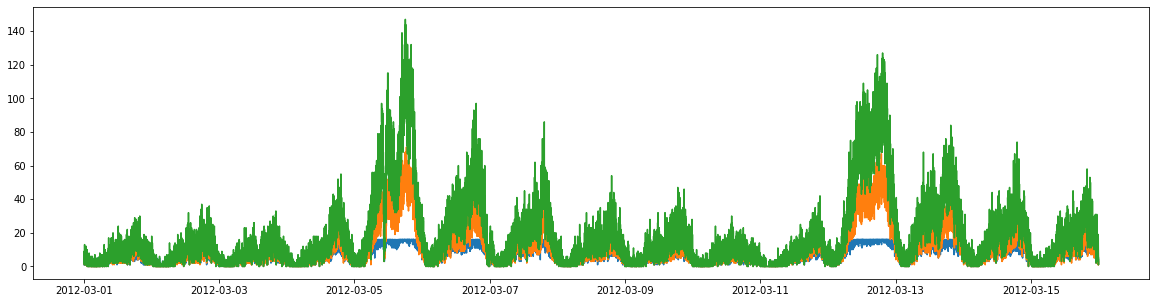

In [4]:
plt.figure(figsize=(20,5))
plt.plot(training_data)
plt.show()

## 3) Creating the RCF Model

We train the model with SageMaker built-in RandomCutForest algorithm. The algorithm takes a bunch of random data points (Random), cuts them to the same number of points and creates trees (Cut). It then looks at all of the trees together (Forest) to determine whether a particular data point is an anomaly. 

A tree is an ordered way of storing numerical data. The simplest type of tree is called a binary tree. It’s a great way to store data because it’s easy and fast for a computer to use. To create a tree, you randomly subdivide the data points until you isolate the point you’re testing to determine whether it’s an anomaly. Each time you subdivide the data points, it creates a new level of the tree.  

The fewer times you need to subdivide the data points before you isolate the target data point the more likely it is that the data point is an anomaly for that sample of data.

In [5]:
session = sagemaker.Session()
bucket = session.default_bucket()
prefix = 'rcf-clickstream'
execution_role = sagemaker.get_execution_role()
bucket, prefix

('sagemaker-us-east-2-322537213286', 'rcf-clickstream')

Particular to a SageMaker RCF training job are the following hyperparameters:

* **num_samples_per_tree** - the number randomly sampled data points sent to each tree. As a general rule, 1/num_samples_per_tree should approximate the the estimated ratio of anomalies to normal points in the dataset.
* **num_trees** - the number of trees to create in the forest. Each tree learns a separate model from different samples of data. The full forest model uses the mean predicted anomaly score from each constituent tree.
* **feature_dim** - the dimension of each data point.

In addition to these RCF model hyperparameters, we provide additional parameters defining things like the EC2 instance type on which training will run, the S3 bucket containing the data, and the AWS access role. Note that,

* Recommended instance type: ml.m4, ml.c4, or ml.c5
* Current limitations:
    * The RCF algorithm does not take advantage of GPU hardware.

In [6]:
# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=512,
                      num_trees=50)

There is an utility record_set() that can be used to upload data to S3 and creates RecordSet to be passed to the fit call.

In [7]:
# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(training_data.to_numpy()))

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-08-21 05:22:05 Starting - Starting the training job...
2020-08-21 05:22:07 Starting - Launching requested ML instances......
2020-08-21 05:23:13 Starting - Preparing the instances for training......
2020-08-21 05:24:23 Downloading - Downloading input data
2020-08-21 05:24:23 Training - Downloading the training image......
2020-08-21 05:25:33 Uploading - Uploading generated training model
2020-08-21 05:25:33 Completed - Training job completed
Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python2.7/site-packages/scipy/_lib/_numpy_compat.py:10: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing.nosetester import import_nose
/opt/amazon/lib/python2.7/site-packages/scipy/stats/morestats.py:12: DeprecationWarning: Importing from numpy.testing.decorators is deprecated, import from numpy.testing instead.
  from numpy.testing.decorators import 

## 4) Predicting the Model

After you train your model, you can deploy it to get predictions. You can detect unexpected spikes in your website with this endpoint.

In [8]:
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!

We set the serializer and predict the anomaly score for training dataset using deployed model. We can pass data in a variety of formats to our inference endpoint. In this example we will demonstrate passing CSV-formatted data. Other available formats are JSON-formatted and RecordIO Protobuf. We make use of the SageMaker Python SDK utilities csv_serializer and json_deserializer when configuring the inference endpoint.

In [9]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer

We will pass the training dataset in CSV format to this inference endpoint in order to automatically detect anomalies which were observed with our human eye in the above plot.

Then, check the first 6 data points to see what the output looks like.

In [10]:
results = rcf_inference.predict(training_data.to_numpy())
results['scores'][:10]

[{'score': 1.1515257361},
 {'score': 1.3891255087},
 {'score': 1.6568821789},
 {'score': 1.0974700205},
 {'score': 1.0206346079},
 {'score': 1.0206346079},
 {'score': 1.5425063999},
 {'score': 1.2701385037},
 {'score': 1.0611711758},
 {'score': 1.0824312171}]

Next, let's look at the distribution of our anomaly score. Drawing a histogram is often useful when deciding the threshold of anomaly scores. We will choose a value around 4.5. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbcb583ca58>]],
      dtype=object)

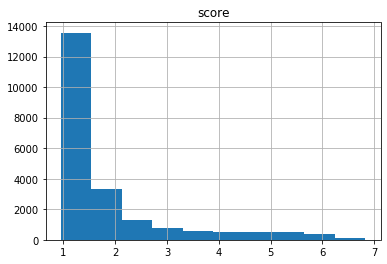

In [11]:
results_pd = pd.DataFrame(results['scores'])
results_pd.hist()

## 5) Plotting the Prediction

The code below will plot our time sereis with anomalies. The algorithm detected anomalies accroding to the changes and deviations in each feature value instead of using a fixed threshold.

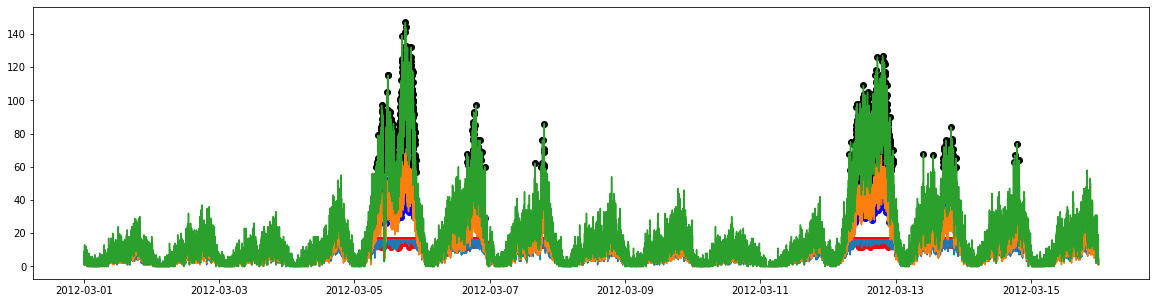

In [12]:
plt.figure(figsize=(20,5))
plt.plot(training_data)
threshold = 4.5
anomalous = training_data[list((results_pd > threshold)['score'])]
plt.scatter(x= anomalous.index, y=anomalous['urls'].values, c='red')
plt.scatter(x= anomalous.index, y=anomalous['users'].values, c='blue')
plt.scatter(x= anomalous.index, y=anomalous['clicks'].values, c='black')
plt.show()

The graph above may seem too complicated. Let's zoom in the time from March 13, 2012 8:00 to March 13, 2012 23:00 to look at the results in detail.

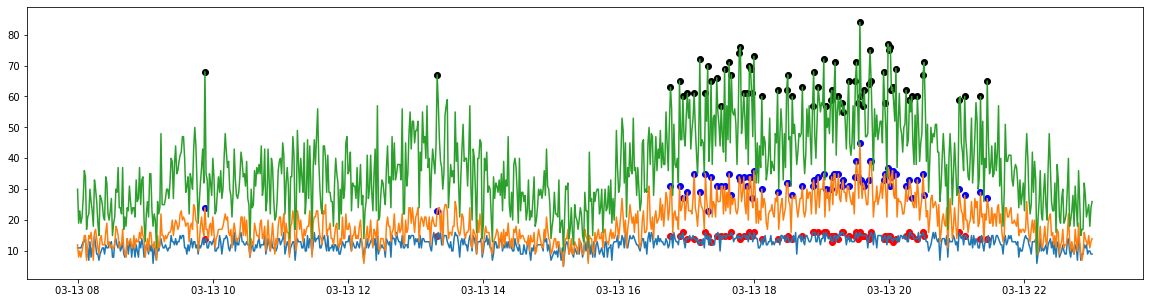

In [13]:
plt.figure(figsize=(20,5))
plt.plot(training_data["2012-03-13 08:00:00":"2012-03-13 23:00:00"])
threshold = 4.5
anomalous = training_data[list((results_pd > threshold)['score'])]["2012-03-13 08:00:00":"2012-03-13 23:00:00"]
plt.scatter(x= anomalous.index, y=anomalous['urls'].values, c='red')
plt.scatter(x= anomalous.index, y=anomalous['users'].values, c='blue')
plt.scatter(x= anomalous.index, y=anomalous['clicks'].values, c='black')
plt.show()

To examine the relationship between anomaly scores and feature deviations, we plot the residuals of clicks and users. The graph below illustrates this change. We can understand that anomalous sources were returned, not only by residual or just the amount of value.

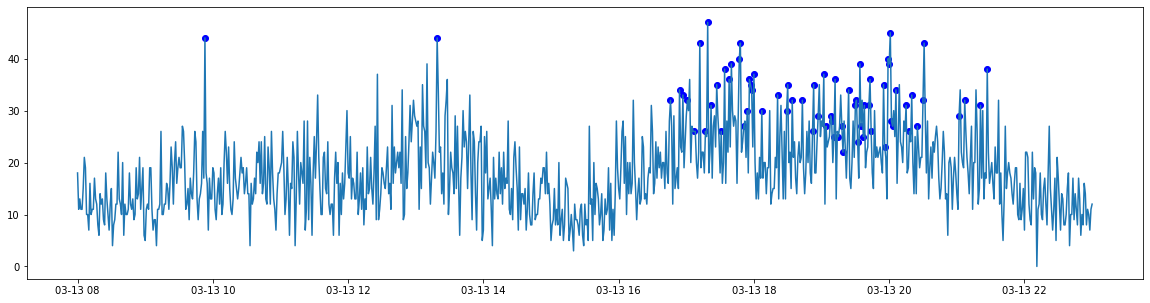

In [14]:
plt.figure(figsize=(20,5))
plt.plot(training_data['clicks']-training_data['users']["2012-03-13 08:00:00":"2012-03-13 23:00:00"])
plt.scatter(x= anomalous.index, y=anomalous['clicks'].values - anomalous['users'].values, c='blue')
plt.show()

We zoom in the time period from March 5, 2012 21:30 to March 6, 2012 17:30 again to look at the detecting abnormal spike. 

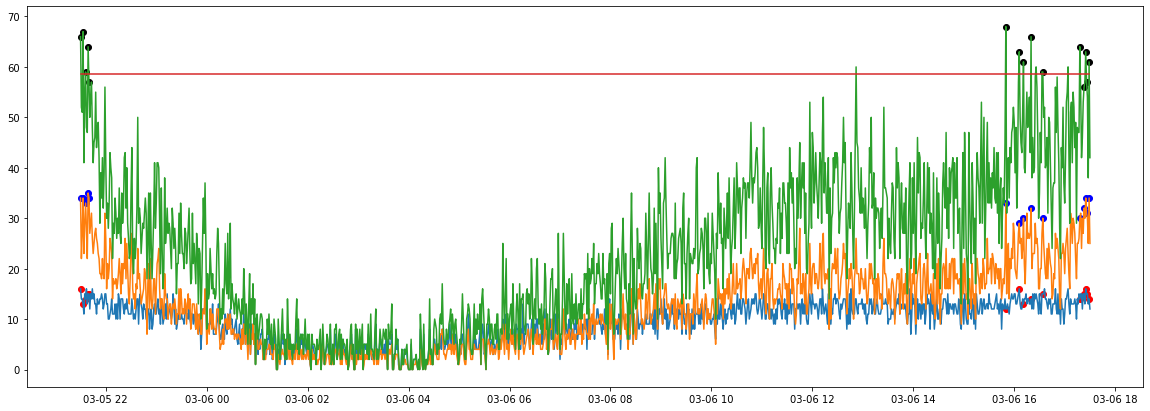

In [15]:
plt.figure(figsize=(20,7))
plt.plot(training_data["2012-03-05 21:30:00":"2012-03-06 17:30:00"])
threshold = 4.5
anomalous = training_data[list((results_pd > threshold)['score'])]["2012-03-05 21:30:00":"2012-03-06 17:30:00"]
plt.scatter(x= anomalous.index, y=anomalous['urls'].values, c='red')
plt.scatter(x= anomalous.index, y=anomalous['users'].values, c='blue')
plt.scatter(x= anomalous.index, y=anomalous['clicks'].values, c='black')
plt.plot(pd.DataFrame([58.5]*len(anomalous.index)).set_index(anomalous.index))
plt.show()

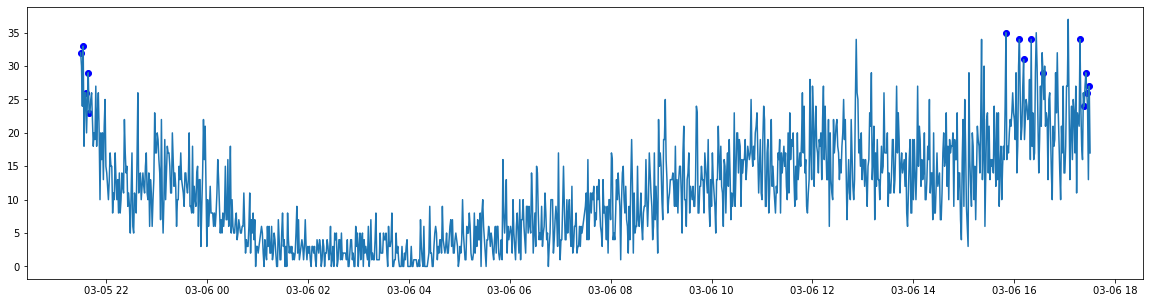

In [16]:
plt.figure(figsize=(20,5))
plt.plot(training_data['clicks']-training_data['users']["2012-03-05 21:30:00":"2012-03-06 17:30:00"])
plt.scatter(x= anomalous.index, y=anomalous['clicks'].values - anomalous['users'].values, c='blue')
plt.show()

## Stop and Delete the Endpoint

Finally, we should delete the endpoint before we close the notebook.

To do this, execute the cell below. Alternately, you can navigate to the "Endpoints" tab in the SageMaker console, select the endpoint with the name stored in the variable endpoint_name, and select "Delete" from the "Actions" dropdown menu.

In [17]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)